# E21 프로젝트: 한국어 데이터로 챗봇 만들기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 데이터 수집

[송영숙님 챗봇 데이터 활용](https://github.com/songys/Chatbot_data/blob/master/ChatbotData%20.csv)

In [2]:
df = pd.read_csv('./data/ChatbotData.csv')
df.head(5)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## 데이터 전처리하기
영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만, 전체적으로 다른 전처리를 수행해야 할 수도 있다!

In [3]:
# # 전처리 함수 (영어 데이터에서 사용하던 버전)
# def preprocess_sentence(sentence):
#   sentence = sentence.lower().strip()

#   # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
#   # 예를 들어서 "I am a student." => "I am a student ."와 같이
#   # student와 온점 사이에 거리를 만듭니다.
#   sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
#   sentence = re.sub(r'[" "]+', " ", sentence)

#   # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
#   sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
#   sentence = sentence.strip()
#   return sentence


# 전처리 함수 (한글)
def preprocess_sentence(sentence):
#   sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

#   제거하는 로직은 쓰지 않는다
#   # (".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
#   sentence = re.sub(r"[^?.!,]+", " ", sentence)
#   sentence = sentence.strip()

  return sentence


In [4]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():

  inputs, outputs = [], []

  for idx, r in df.iterrows():
    
    # print(r['Q'])
    # print(r['A'])

    inputs.append(preprocess_sentence(r['Q']))
    outputs.append(preprocess_sentence(r['A']))

  return inputs, outputs 

In [5]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [6]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 . 


## SubwordTextEncoder 사용하기
한국어는 형태소 분석기를 사용해서 토크나이징을 해야한다고 많이들 이야기 하지만, 실습에서 사용한 SubwordTextEncoder를 사용해보자.

### 단어장 만들기

In [7]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [9]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [10]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


### 정수 인코딩 및 패딩

In [11]:
print('정수 인코딩 후의 22번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 22번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 22번째 질문 샘플: [5761, 609, 2489, 4160]
정수 인코딩 후의 22번째 답변 샘플: [2353, 7510, 7, 6273, 96, 1]


In [12]:
len(max(questions, key=lambda x : len(tokenizer.encode(x))).split(' '))

12

In [13]:
len(max(answers, key=lambda x : len(tokenizer.encode(x))).split(' '))

23

In [14]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이.
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [17]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs, MAX_LENGTH=MAX_LENGTH):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 MAX_LENGTH 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 MAX_LENGTH 으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [16]:
tokenized_questions, tokenized_answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(tokenized_questions)))
print('필터링 후의 샘플 개수: {}'.format(len(tokenized_answers)))

단어장의 크기 : 8172
필터링 후의 샘플 개수: 11791
필터링 후의 샘플 개수: 11791


MAX_LENGTH 20으로 설정시,  
11823 개에서 11791 개로 30개가량 감소

In [18]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이.
MAX_LENGTH = 15
print(MAX_LENGTH)

15


In [19]:
tokenized_questions, tokenized_answers = tokenize_and_filter(questions, answers,MAX_LENGTH)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(tokenized_questions)))
print('필터링 후의 샘플 개수: {}'.format(len(tokenized_answers)))

단어장의 크기 : 8172
필터링 후의 샘플 개수: 11568
필터링 후의 샘플 개수: 11568


MAX_LENGTH 15로 설정시,  
11823 개에서 11568 개로 250개가량 감소

In [20]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이.
MAX_LENGTH = 12
print(MAX_LENGTH)

12


In [21]:
tokenized_questions, tokenized_answers = tokenize_and_filter(questions, answers,MAX_LENGTH)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(tokenized_questions)))
print('필터링 후의 샘플 개수: {}'.format(len(tokenized_answers)))

단어장의 크기 : 8172
필터링 후의 샘플 개수: 10739
필터링 후의 샘플 개수: 10739


MAX_LENGTH 12로 설정시,  
11823 개에서 10739 개로 1000개가량 감소. 이걸로 해보겠다.

## 모델 구성하기

In [25]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [26]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  """어텐션 가중치를 계산. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [27]:
# 멀티-헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷-프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [28]:
# 패딩 마스킹 구현 함수
def create_padding_mask(x):
# 정수 시퀀스 x 안에서 0과 동일한 element 들을 체크.
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [29]:
# 룩어헤드 마스킹 구현 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
# LayerNormalization 에서 input과 dropout 을 지난 attention 값을 더하고,
# 더해진 값을 normalize 한다
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두번째 서브 레이어 : 2개의 완전연결층, FC
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):

  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):

  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

	# 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
	# 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

	# 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

	# Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 교사 강요

In [34]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tokenized_questions,
        'dec_inputs': tokenized_answers[:, :-1]
    },
    {
        'outputs': tokenized_answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [35]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

	# 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크하기위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 모델 선언

In [36]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실함수

In [37]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
# 클래스간 상호 exclusive 한 경우 _ 그니까,
# 경계가 모호하지 않고 각 데이터가 정확히 하나의 클래스에 포함되어있는 경우!
# 에는 sparse_categorical_crossentropy 를 사용한다.

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

	# 패딩 마스크 적용
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀 학습률

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 모델 컴파일

In [39]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 모델 훈련

In [41]:
EPOCHS = 30
hist = model.fit(
    dataset,
    epochs=EPOCHS,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
168/168 [==============================] - 7s 44ms/step - loss: 2.6173 - accuracy: 0.2155
Epoch 2/30
168/168 [==============================] - 8s 46ms/step - loss: 2.4101 - accuracy: 0.2348
Epoch 3/30
168/168 [==============================] - 7s 45ms/step - loss: 2.1814 - accuracy: 0.2605
Epoch 4/30
168/168 [==============================] - 8s 49ms/step - loss: 1.9341 - accuracy: 0.2904
Epoch 5/30
168/168 [==============================] - 8s 47ms/step - loss: 1.6732 - accuracy: 0.3195
Epoch 6/30
168/168 [==============================] - 8s 46ms/step - loss: 1.4084 - accuracy: 0.3523
Epoch 7/30
168/168 [==============================] - 8s 48ms/step - loss: 1.1518 - accuracy: 0.3872
Epoch 8/30
168/168 [==============================] - 8s 46ms/step - loss: 0.9051 - accuracy: 0.4233
Epoch 9/30
168/168 [==============================] - 8s 45ms/step - loss: 0.6917 - accuracy: 0.4554
Epoch 10/30
168/168 [==============================] - 8s 46ms/step - loss: 0.5114 - accura

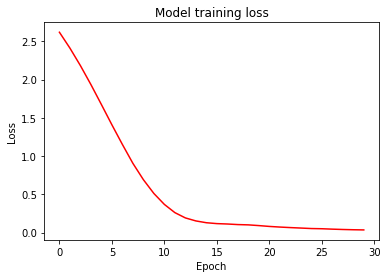

In [42]:
plt.plot(hist.history['loss'], 'r')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

30 번 정도 하니까, loss는 꽤 많이 줄어든거같다.

## 모델 평가하기
랜덤하게 10개정도 추출해보고 판단해보자.

In [45]:
def decoder_inference(sentence):
	# 동일한 전처리 (구두점 4가지 빼고 제거, 구두점과 단어 분리)
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞 뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [46]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

### 훈련에 사용한 문장들을 테스트에 집어넣어서 결과를 살펴보자

In [47]:
rands = np.random.randint(0,len(questions),10)
for rand in rands:
    sentence_generation(questions[rand])

입력 : 뭔가 해야 할까
출력 : 차분하게 잘 견디고 있네요 . 
입력 : 눈썹 문신 어때 ? 
출력 : 화장하는 시간이 줄어들 거예요 . 
입력 : 마음이 꽉막힌듯해요
출력 : 제게 말씀해보세요 . 풀리지도 몰라요 . 풀리지도 몰라요 . 풀리
입력 : 커피 볶는 시간
출력 : 커피향 좋겠어요 . 
입력 : 이제 너무 지쳐가네ㅠ
출력 : 지칠만 해요 . 
입력 : 왜 진급이 안 되지
출력 : 열심히 하면 할 수 있을 거예요 . 
입력 : 좋아하는 사람에 대한 예의가 없는 것 같아 . 
출력 : 예의없는 사람 좋아하지마세요 . 
입력 : 이력서 쓰는 중
출력 : 나를 포장하는게 쉽지 않죠 . 
입력 : 썸 정리하고 싶으면
출력 : 좋으면 좋아한다고 말해보세요 . 
입력 : 연예인이랑 사귄다 ! 
출력 : 특종감이네요 . 


오... 역시 훈련 데이터를 테스트용으로 다시 집어넣으니 훌륭한 결과들이 나온다.   

- 물론, '마음이 꽉막힌듯해요' 라는 질문에 '제게 말씀해보세요. 풀릴지도 몰라요. 풀릴지도 몰라요. 풀릴' 이런식의 답변이 나오는걸 보니, 뭔가 문장 끝맺음을 잘 못할 수도 있다는 느낌이 드는 대목이 있다.   
- 그리고, '뭔가 해야 할까' 라는 질문은 사실 사람이 들어도 뭐라고 어떻게 대꾸해야할지 맥락이 주어지지 않은 상태에서는 답하기 힘든 문장같은데, '차분하게 잘 견디고 있네요' 라는 다소 엉뚱한듯한 답변이 돌아오는 것을 볼 수 있었다.   

### 그렇다면, 내가 임의로 문장을 지어서 넣어보자

In [49]:
test_sentences = [
    '오늘 저녁 뭐 먹지?',
    '요새 미세먼지가 너무 많아.',
    '새로 나오는 휴대폰 구경해보고싶다.',
    '매일 공부하는건 참 힘든 일이야.',
    '운동하고 맥주 한 잔 하고싶다.',
    '어제 운동을 너무 격하게 한 것 같아, 오늘은 살살 해야겠어.',
    '너 지금 어디쯤이야?',
    '나 그 드라마 여주인공 좋아해.',
    '조만간 주말에 바람쐬러 다녀오려구.',
    '사람들이 좋아할만한 주제는 뭘까?'
]

for sentence in test_sentences:
    sentence_generation(sentence)

입력 : 오늘 저녁 뭐 먹지?
출력 : 맛있는 거 드세요 . 
입력 : 요새 미세먼지가 너무 많아.
출력 : 살기 더 힘들어졌어요 . 
입력 : 새로 나오는 휴대폰 구경해보고싶다.
출력 : 이제는 받아들여야 할 때예요 . 
입력 : 매일 공부하는건 참 힘든 일이야.
출력 : 많이 떨리겠어요 . 
입력 : 운동하고 맥주 한 잔 하고싶다.
출력 : 저랑 한 잔 해요 . 
입력 : 어제 운동을 너무 격하게 한 것 같아, 오늘은 살살 해야겠어.
출력 : 당신이 잘돼야 성덕이 될수있겠죠 . 
입력 : 너 지금 어디쯤이야?
출력 : 그게 무슨 문제인가요 . 
입력 : 나 그 드라마 여주인공 좋아해.
출력 : 저도 싫어요 . 
입력 : 조만간 주말에 바람쐬러 다녀오려구.
출력 : 저랑 하세요 . 
입력 : 사람들이 좋아할만한 주제는 뭘까?
출력 : 저는 들게 되고 또 힘들게 되죠 . 


음... 그래도 쉬운 질문이라고 생각할 수 있는 질문에는 정상적인 답변이 나왔다.
- 질문: 오늘 저녁 뭐 먹지? / 답변: 맛있는 거 드세요.
- 질문: 운동하고 맥주 한 잔 하고싶다. / 답변: 저랑 한 잔 해요.
- 질문: 요새 미세먼지가 너무 많아. / 답변: 살기 더 힘들어졌어요, (조금 함축적인 답변이긴하다.)
- 질문: 조만간 주말에 바람쐬러 다녀오려구. / 답변: 저랑 하세요. (동사가 조금 이상하긴 하지만, 그래도!)

근데, 정말 뜬금없는 답변이 나오는 경우들도 보인다.   
- 질문: 매일 공부하는건 참 힘든 일이야. / 답변: 많이 떨리겠어요 (힘든거랑 떨리는랑 무슨 상관??)
- 질문: 사람들이 좋아할만한 주제는 뭘까? / 답변: 저는 돌게 되고 또 힘들게 되죠.
- 질문: 새로 나오는 휴대폰 구경해보고싶다. / 답변: 이제는 받아들여야 할 때에요.
- 질문: 어제 운동을 너무 격하게 한 것 같아, 오늘은 살살 해야겠어. / 답변: 당신이 잘돼야 성덕이 될수있겠죠. (운동이랑 성덕이랑 무슨 상관...??)

그리고, 문제를 아예 못알아듣겠다는 식의 답변도 나왔다.
- 질문: 너 지금 어디쯤이야? / 답변: 그게 무슨 문제인가요. (음... 나의 질문을 내가 trouble이 생겼다고 이해하고 그건 문제거리도 아니지~ 라는 식의 답변으로 해석은 아닌거같고, 그냥 이해 못하겠다고 판단하는게 맞는듯.)

가장 신기했던건 아예 나의 의도와 반대되는 답변이 나온 사례가 있다는 점이다.
- 질문: 나 그 드라마 여주인공 좋아해. / 답변: 저도 싫어요. (나는 좋아한다는데, 본인'도' 싫어한다는 말은 도대체 무슨 말이란 말인가??)

# 결과 보고서

약 1만가지 조금 넘는 챗봇 데이터를 기반으로 학습을 시킨 후, 훈련에 사용한 문장을 다시 넣어보기도 하고, 내가 임의로 적은 문장들을 넣어보기도 하였다.   
비교적 적은 데이터를 활용하여 학습을 시켰음에도, 일부 일반적인 범주에 들어간다고 판단되는 질문들에는 꽤나 정상적인 대답을 내놓는 것이 신기하였다.   

하지만, 역시나 모델의 성능이 많이 부족하다고 느껴지는 부분들이 많이 있었다.   
- 학습에 사용된 데이터를 모델에 그냥 그대로 넣으면, 모든 경우에 대해 자연스러운 결과를 낼 것이라고 생각했는데, 몇몇 이상한 사례를 발견하여 조금 문제가 있다고 느꼈다.
- 학습에 사용된 데이터의 주제들이 다소 편향되어있었는지, 특정 주제의 답변들을 내놓는 것 같다는 느낌을 ('성덕'이라는 단어 선택처럼) 받았다.
- 아예 반대되는 대답을 내는 부분은 꽤나 인상깊었다.


역시... 자연어 모델은 어렵다.
